# The Diffusion Problem
This notebook is an introduction to solving a time-dependent temperature diffusion PDE for a given block of material.  Within the block there is a heat source which drives temperature diffusion. On the surface, energy can radiate into the surrounding environment.
<figure>
    <center>
    <img src="figures/Helmholtz.png", width="400">
    </center>
    <center>
    <caption>The domain $\Omega=[0,l0]\times[0,l1]=\{ (x_0;x_1)~|~0\le x_{0} \le l0 \mbox{ and } 0\le x_{1} \le l1 \}$ for temperature diffusion problem  with heat source.
        </caption></center>
 </figure>
The solution method includes a time integration scheme, the ackward Euler method, and at each step a boundary value problem, the Helmholtz equation, is solved.


## Temperature diffusion equations
The unknown temperature $T$ is a function of its location in the domain and time $t>0$. The governing equation in the interior of the domain is given by
\begin{equation}
\rho c_p \frac{\partial T}{\partial t} - \nabla\cdot(\kappa \nabla T) = q_H
 \tag{1}
\end{equation}
where $\rho c_p$ and $\kappa$ are given material constants. In case of a composite material parameters depend on their location in the domain.
$q_H$ is a heat source (or sink) within the domain.  We assume $q_H$ to be equal to a constant heat production rate $q^{c}$ on a circle or sphere with center $x^c$ and radius $r$, and $0$ elsewhere:
\begin{equation}
q_H(x,t)=\left\{ 
\begin{array}{l l}
    q^c  & \quad\text{if $\|x-x^c\| \le r$}\\
    0    & \quad\text{else}\\
\end{array} \right.
\tag{2}
\end{equation}
for all $x$ in the domain and time $t>0$.

On the boundary of the domain we specify a radiation condition which prescribes the normal component of the flux $\kappa \nabla T$ to be proportional to the difference of the current temperature to the surrounding temperature $T_{ref}$:
\begin{equation}
\mathbf{n}\cdot (\kappa \nabla T) = \eta (T_{ref}-T) 
\tag{3}
\end{equation}
$\eta$ is a given material coefficient depending on the material of the block and the surrounding medium.
$\mathbf{n}$ is the outward normal at the boundary of the domain. 

## Backward Euler
Let $T^{(n)}$ be the temperature at time $t^{(n)}$.  To solve the time-dependent (1), an initial temperature at time $t^{(0)}=0$ has to be given.  For this problem, it is assumed that the initial temperature is the surrounding temperature:
\begin{equation}
T^{(0)}=T_{ref} 
\tag{4}
\end{equation}
for all $x$ in the domain. Note that the initial conditions satisfy the boundary condition defined by (3). The temperature is calculated at discrete time nodes $t^{(n)}$, with $t^{(n)}=t^{(n-1)}+h$, where $h>0$ is the step size, assumed to be constant in this example.  

The simplest and most robust scheme to approximate the time derivative of the temperature is the backward Euler scheme.  It is based on the Taylor expansion of $T$ at time $t^{(n)}$:
\begin{equation}
\frac{\partial T}{\partial t}^{(n)}\approx\frac{T^{(n)}-T^{(n-1)}}{h}
\tag{5}
\end{equation}
Substituting (5) into (1) and rearranging with unknowns on the left and knowns on the right, the time evolution of the temperature is given by

\begin{equation}
- \nabla\cdot(\kappa \nabla T^{(n)}) +\omega T^{(n)}  = q_H +  \omega T^{(n-1)}
\tag{6}
\end{equation}
with 
\begin{equation}
\omega=\frac{\rho c_p}{h}.
\tag{7}
\end{equation}

Together with the natural boundary condition 
\begin{equation}
 \mathbf{n}\cdot (\kappa \nabla T^{(n)}) + \eta T^{(n)}= \eta T_{ref} 
\tag{8}
\end{equation}
taken from (3).  This forms a boundary value problem, the Helmholtz problem, that has to be solved for each time step. 

## Solving The Helmholtz problem
### Step 1. Define the domain.
The function **Rectangle** from *esys-finley* is used to define the domain.  The rectangle used for this example has bottom left corner at $(0,0)$ and top right corner $(5,1)$ with 50 elements in the $x_0$ direction and and 10 elements in the $x_1$ direction.  The commands for creating the domain are   

In [1]:
from esys.finley import Rectangle
mydomain = Rectangle(l0=5., l1=1., n0=50, n1=10)

### Step 2.  Define the PDE and boundary conditions, solve, and output
The PDE is defined using the [**LinearPDE**](LINK) class. This is just a simple example and more details on the class can be found in [**LinearPDE**](LINK). Undefined coefficients in the LinearPDE class are assumed to not be present.  The format of the PDE for the Helmholtz case is 
\begin{equation}
-\nabla\cdot(\mathbf{A}\nabla u) + Du = Y 
\tag{9}
\end{equation}



For a 2D single PDE, $\mathbf{A}$ is a $2\times 2$, rank 2 Data object.  For the Helmholtz case,
\begin{equation}
\mathbf{A}=\begin{pmatrix}\kappa & 0\\ 0 & \kappa\end{pmatrix} 
\end{equation}
$\mathbf{A}$ is symmetric and setting this in the implementation as part of the LinearPDE class.

The other coefficients are scalars,
\begin{equation}
D = \omega = \frac{\rho c_p}{h}\quad \mbox{and}\quad Y = f = q_H +\omega T^{(n-1)}
\end{equation}

For the boundary conditions, the linear single PDE format is 
\begin{equation}
\mathbf{n}\cdot (\mathbf{A}\nabla u) +du = y
\end{equation}
with $\mathbf{A}$ from (9).  The additional coefficients are
\begin{equation}
d=\eta \quad\mbox{and}\quad y= \eta T_{ref}
\end{equation}

To define coefficient $\mathbf{A}$, we use the *esys-escript* **kronecker** function, 
\begin{equation}
\delta_{ij}=\left\{ 
\begin{array}{l l}
    1  & \quad\text{if } i=j\\
    0    & \quad\text{otherwise}\\
\end{array} \right.
\end{equation}

In [2]:
from esys.escript import kronecker
print("kronecker(2)=\n",kronecker(2))

kronecker(2)=
 [[1. 0.]
 [0. 1.]]


The outward normal on the domain is required to apply the boundary conditions. This is a property of the **Domain**class.

In [3]:
n=mydomain.getNormal()

To test the implementation, we solve the Helmholtz equation on a rectangular domain of length $l_{0}=5$ and height $l_{1}=1$.  We choose a simple test solution such that we can verify the returned solution against the exact answer. For this we assume $T=x_{0}$ (with
$q_H = 0$) and then calculate right hand side terms $\omega T^{(n-1)}$ and $\eta T_{ref}$ such that the test solution becomes the solution of the problem. If we assume $\kappa$ is constant, an easy calculation shows that we have to choose $\omega T^{(n-1)}=\omega x_{0}$.
On the boundary we get $\eta T_{ref} = \kappa n_0+\eta x_0$.  The result is displayed using matplotlib, but could easily be exported as a silo or vtu file.

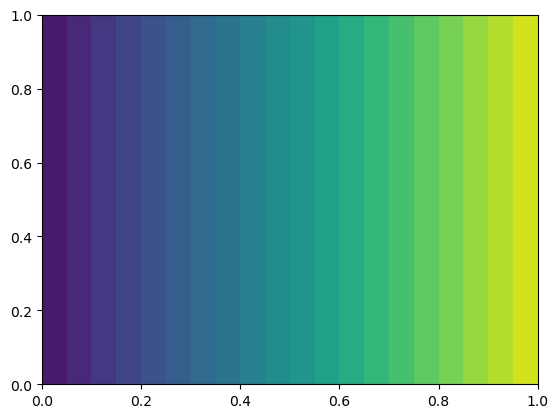

In [4]:
from esys.escript import *
from esys.escript.linearPDEs import LinearPDE
from esys.finley import Rectangle
from scipy.interpolate import griddata
import numpy as np
from matplotlib import pyplot as plt

# set some parameters
kappa = 1.
omega = 0.1
eta = 10.

# generate domain
mydomain = Rectangle(l0=5., l1=1., n0=50, n1=10)

# open PDE and set coefficients
mypde = LinearPDE(mydomain)
mypde.setSymmetryOn()
n = mydomain.getNormal()
x = mydomain.getX()
oldT = x[0]
mypde.setValue(A=kappa*kronecker(mydomain), D=omega, Y=omega*oldT)
# Boundary conditions
mypde.setValue(d=eta, y=kappa*n[0]+eta*oldT)
# calculate error of the PDE solution
newT = mypde.getSolution()

# plotting 

# interpolate to grid and plot
x_grid = np.linspace(0., 1., 51, endpoint=True)
y_grid = np.linspace(0., 1., 11, endpoint=True)
x=mydomain.getX()[0].toListOfTuples()
y=mydomain.getX()[1].toListOfTuples()
z = interpolate(newT, mydomain.getX().getFunctionSpace())
newTt = newT.toListOfTuples()
newTt_grid = griddata((x,y),newTt,(x_grid[None,:],y_grid[:,None]),'linear')
plt.contourf(x_grid, y_grid, newTt_grid, 20)
plt.show()